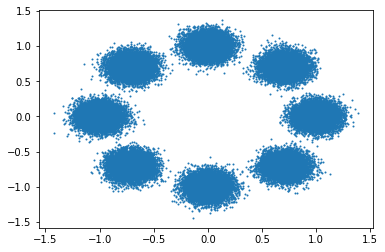

In [110]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # return self.data[idx], self.label[idx]
        return self.data[idx]


data_size = 80000
dataset = CustomDataSet(n_group=8, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [0]:
def noise(mb_size, noise_size):
    return torch.randn(mb_size, noise_size)


def gnllloss(mu, sig, tar):
    return torch.sum(torch.log(sig) + 0.5 * (np.log(2.0 *3.141592) + ((mu - tar)/sig)**2), dim=1).mean()


def sampling(mu, sig):
    return sig * torch.FloatTensor(sig.size()).normal_() + mu


def KLDLoss(mu, sig): #KL(N(mu, sig) || N(0, I))
    return (0.5 * torch.sum(mu*mu + sig*sig - 2.0 * torch.log(sig) - 1.0, dim=1)).mean()

In [0]:
mb_size = 64
Z_dim = 2
X_dim = 2

class NormalDensityNetwork(torch.nn.Module):

    def __init__(self, n_in, n_out):
        super(NormalDensityNetwork, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=n_in, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=24, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=24, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.mean = torch.nn.Linear(in_features=16, out_features=n_out, bias=True)
        self.log_var = torch.nn.Linear(in_features=16, out_features=n_out, bias=True)


    def forward(self, x):
        x = self.layer(x)
        return self.mean(x), torch.exp(0.5 * self.log_var(x))


class Classifier(torch.nn.Module):
    def __init__(self, n_in):
        super(Classifier, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=n_in, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=8, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=8, out_features=1, bias=True),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x)


D = Classifier(n_in=Z_dim)
Q = NormalDensityNetwork(n_in=X_dim, n_out=Z_dim)
P = NormalDensityNetwork(n_in=Z_dim, n_out=X_dim)
D_solver = optim.Adam(D.parameters(), lr=1e-3)
Q_solver = optim.Adam(Q.parameters(), lr=1e-3)
P_solver = optim.Adam(P.parameters(), lr=1e-3)

In [0]:
NLL = []
KLD = []
D_REAL = []
D_FAKE = []
ones_label = torch.ones(mb_size, 1)
zeros_label = torch.zeros(mb_size, 1)
loader = DataLoader(dataset, batch_size=mb_size, shuffle=True, drop_last=True)

In [0]:
num_epochs = 100
for epoch in range(num_epochs):
    NLL_CUM = 0.0
    KLD_CUM = 0.0
    D_REAL_CUM = 0.0
    D_FAKE_CUM = 0.0
    for _, X in enumerate(loader):
        Q_solver.zero_grad()
        P_solver.zero_grad()
        z_mu, z_sig = Q(X)
        Z = sampling(z_mu, z_sig)
        kld = KLDLoss(z_mu, z_sig)
        D_loss = nn.binary_cross_entropy(D(Z), ones_label)
        x_mu, x_sig = P(Z)
        gnll = gnllloss(x_mu, x_sig, X)
        (gnll + D_loss).backward()
        Q_solver.step()
        P_solver.step()

        D_solver.zero_grad()
        Z = torch.from_numpy(Z.data.numpy())
        D_fake = D(Z)
        D_real = D(torch.rand_like(Z))
        D_fake_loss = nn.binary_cross_entropy(D_fake, zeros_label)
        D_real_loss = nn.binary_cross_entropy(D_real, ones_label)
        (D_real_loss + D_fake_loss).backward()
        D_solver.step()

        NLL_CUM += gnll.item()
        KLD_CUM += kld.item()
        D_REAL_CUM += D_real.mean().item()
        D_FAKE_CUM += D_fake.mean().item()

    NLL.append(NLL_CUM / len(loader))
    KLD.append(KLD_CUM / len(loader))
    D_REAL.append(D_REAL_CUM / len(loader))
    D_FAKE.append(D_FAKE_CUM / len(loader))

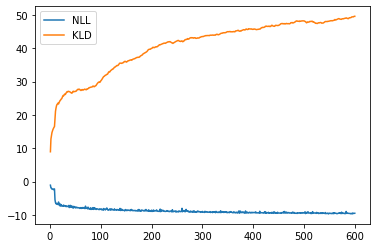

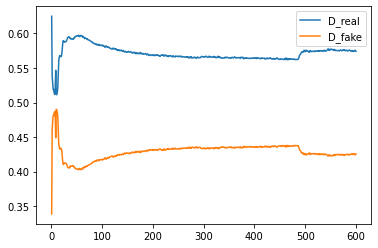

In [132]:
plt.plot(np.arange(1, len(NLL) + 1), NLL, label='NLL')
plt.plot(np.arange(1, len(KLD) + 1), KLD, label='KLD')

plt.legend()
plt.show()

plt.plot(np.arange(1, len(D_REAL) + 1), D_REAL, label='D_real')
plt.plot(np.arange(1, len(D_FAKE) + 1), D_FAKE, label='D_fake')
plt.legend()
plt.show()

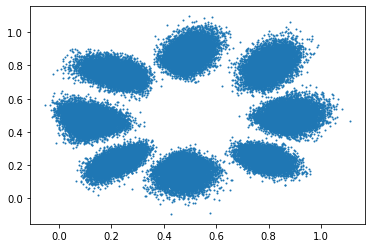

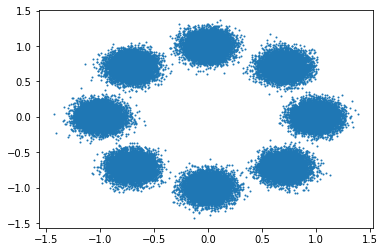

In [133]:
z_mu, z_sig = Q(dataset.data)
z = sampling(z_mu, z_sig)
x_mu, x_sig = P(z)
x = sampling(x_mu, x_sig).data.numpy()

z = z.data.numpy()
plt.scatter(z[:, 0], z[:, 1], s=1)
plt.show()
plt.scatter(x[:, 0], x[:, 1], s=1)
plt.show()

